In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.optimization.applications.ising import max_cut
from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer,GroverOptimizer
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model

In [2]:
###### Fucntion for creating random adjacency matrix. #########

def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(i,number_of_vertices):
            if random.random()>probability or i==j:
                adj_matrix[i,j]=0
                adj_matrix[j,i]=0

    return adj_matrix

In [3]:
###### Function for converting binary number to decimal #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    
    return binary

In [4]:
####### Using Brute force ########

def brute_force(n, adj_matrix):
    best_cost = 0
    best_case = None
    for k in range(2**n):
        binary_k=dec_to_bin(k, n)
        temp_cost = 0
        for i in range(n):
            for j in range(n):
                temp_cost = temp_cost + adj_matrix[i,j]*binary_k[i]*(1-binary_k[j])
        if temp_cost > best_cost:
            best_cost = temp_cost
            best_case = binary_k

    return best_cost

In [5]:
######## function for getting n dependant cost and time using brute force ##########

def get_cost_and_time_vs_n(n1, n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(brute_force(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n.append((x, y))
        time_vs_n.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n, time_vs_n

In [19]:
######## Function for getting cost using numpyeigensolver ############

def using_numpyeigensolver(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = solver.solve(qudratic)
    best_cost = -1*result.fval
    return best_cost


In [7]:
########  function for getting n dependant cost and time using Numpyeigensolver #########

def get_cost_and_time_numpyeigensolver(n1, n2):
    cost_vs_n_fromeigensolver = list()
    time_vs_n_fromeigensolver = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(using_numpyeigensolver(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromeigensolver.append((x, y))
        time_vs_n_fromeigensolver.append((x, z))
        print("n=", x, "cost=",  y, "time=",  z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver

In [8]:
def using_vqe(n, adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    seed = 10598
    backend = Aer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    spsa = SPSA(maxiter=300)
    ry = TwoLocal(qubitop.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
    vqe = VQE(qubitop, ry, spsa, quantum_instance=quantum_instance)
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qudratic)
    return -1*result.fval
using_vqe(5,create_adjacency_matrix(5,0.5))

4.0

In [9]:
########  function for getting n dependant cost and time using VQE #########

def get_cost_and_time_VQE(n1, n2):
    cost_vs_n_fromVQE = list()
    time_vs_n_fromVQE = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(using_vqe(j, create_adjacency_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromVQE.append((x, y))
        time_vs_n_fromVQE.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromVQE, time_vs_n_fromVQE

In [10]:
def cost_qaoa(n, adj_matrix):
    operator, offset = max_cut.get_operator(adj_matrix)
    seed = 10598
    backend = Aer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    spsa = SPSA(maxiter=300)
    qaoa_API = QAOA(operator, spsa, p = 4, max_evals_grouped = 1 ,quantum_instance = quantum_instance )
    result = QAOA.find_minimum(qaoa_API)
    cost = -1*(result['optimal_value']+offset)
    tim = result['optimizer_time']
    return cost, tim
cost_qaoa(9,create_adjacency_matrix(9,0.5))

(5.79619032726046, 17.258949518203735)

In [11]:
def get_cost_and_time_QAOA(n1, n2):
    cost_vs_n_fromQAOA = list()
    time_vs_n_fromQAOA = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            temp_cost, temp_time = cost_qaoa(j, create_adjacency_matrix(j, 0.5))
            cost.append(temp_cost)
            tim.append(temp_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromQAOA.append((x, y))
        time_vs_n_fromQAOA.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromQAOA, time_vs_n_fromQAOA

In [12]:
def using_grover(n,adj_matrix):
    qubitop, offset = max_cut.get_operator(adj_matrix)
    qudratic = QuadraticProgram()
    qudratic.from_ising(qubitop, offset)
    backend = BasicAer.get_backend('statevector_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance=backend)
    solver = MinimumEigenOptimizer(grover_optimizer)
    results = grover_optimizer.solve(qudratic)
    print("x={}".format(results.x))
    print("fval={}".format(results.fval))
#using_grover(5,create_adjacency_matrix(5,0.5))

In [21]:
######## getting cost and time from every method #########

print("Cost and time using Brute Force")
cost_vs_n, time_vs_n = get_cost_and_time_vs_n(4, 12)

print("")

print("Cost and time using NumpyEigenSolver")
cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver = get_cost_and_time_numpyeigensolver(4, 12)

print("")

print("Cost and time using VQE")
cost_vs_n_fromVQE, time_vs_n_fromVQE = get_cost_and_time_VQE(4, 12)

print("")

print("Cost and time using QAOA")
cost_vs_n_fromQAOA, time_vs_n_fromQAOA = get_cost_and_time_QAOA(4, 12)

Cost and time using Brute Force
n= 4 cost= 1.8 time= 0.0007982254028320312
n= 5 cost= 4.2 time= 0.0017920970916748048
n= 6 cost= 4.6 time= 0.005188751220703125
n= 7 cost= 8.2 time= 0.007579517364501953
n= 8 cost= 10.6 time= 0.015964269638061523
n= 9 cost= 12.4 time= 0.0436826229095459
n= 10 cost= 17.0 time= 0.10132865905761719
n= 11 cost= 21.2 time= 0.24075617790222167

Cost and time using NumpyEigenSolver
n= 4 cost= 2.4 time= 0.021939659118652345
n= 5 cost= 4.0 time= 0.02593121528625488
n= 6 cost= 5.6 time= 0.0315147876739502
n= 7 cost= 7.8 time= 0.03970017433166504
n= 8 cost= 11.2 time= 0.05166172981262207
n= 9 cost= 14.6 time= 0.08397703170776367
n= 10 cost= 15.8 time= 0.05524883270263672
n= 11 cost= 19.6 time= 0.06602225303649903

Cost and time using VQE
n= 4 cost= 2.8 time= 3.04445538520813
n= 5 cost= 4.4 time= 3.220783519744873
n= 6 cost= 6.8 time= 4.196621942520141
n= 7 cost= 8.2 time= 4.47750415802002
n= 8 cost= 11.2 time= 5.200938940048218
n= 9 cost= 13.0 time= 7.4658497810363

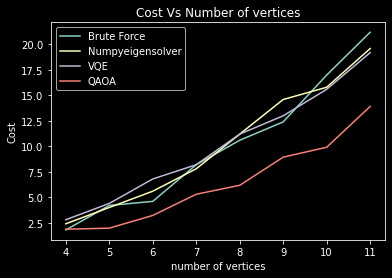

In [22]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
x, y = zip(*cost_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*cost_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*cost_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*cost_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()


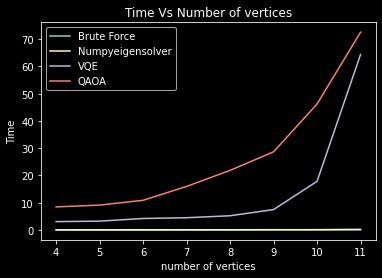

In [23]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
x, y = zip(*time_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*time_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*time_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*time_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()